# ROC curves of TNKF-LSSVM and LS-SVM

Import packages

In [74]:
import os
from sklearn import metrics

import numpy as np
import pandas as pd
import mat73
import matplotlib.pyplot as plt
# import matplotlib
import tikzplotlib

from tusz_data_processing.config import FEATURES_DIR, TUSZ_DIR
# import tusz_data_processing.load_functions as lf
%matplotlib qt

Set global variables

In [75]:
RESULTS_FOLDER = FEATURES_DIR + "/results/"
LSSVM_DEV = RESULTS_FOLDER + "lssvm/dev1_output.csv"
LSSVM_EVAL = RESULTS_FOLDER + "lssvm/eval1_output.csv"
TNKF_DEV = RESULTS_FOLDER + "tnkf_subset/dev_1.csv"
TNKF_EVAL = RESULTS_FOLDER + "tnkf_subset/eval_1.csv"
TNKF_DEV_FULL = RESULTS_FOLDER + "gamma=0.10_sigma2=6.00/predicted.mat"
TNKF_EVAL_FULL = RESULTS_FOLDER + "eval/gamma=0.10_sigma2=6.00/predicted.mat"


In [76]:
def load_predictions(prediction_file):
    # %% Load predictions
    prediction_file = os.path.abspath(prediction_file)
    file, ext = os.path.splitext(prediction_file)
    if ext == ".mat":
        predictions = mat73.loadmat(prediction_file)
        predictions = pd.DataFrame(predictions)
    elif ext == ".csv":
        predictions = pd.read_csv(prediction_file)
    else:
        raise Exception("Function not defined for files of this type.")
    # predictions had cols: 'predicted_labels', 'svm_output', (opt.) 'vat_output'
    predictions.reset_index(inplace=True, drop=True)
    return predictions

In [77]:
def get_roc_from_predictions(predictions: pd.DataFrame, labels = []):
    labels = np.asarray(labels)
    if 'y_val' in predictions:
        labels = predictions['y_val'].to_numpy()
    elif len(labels)<1:    # y_true empty and not in predictions dataframe
        raise Exception("No labels provided or in prediction dataframe.")

    fpr, tpr, _ = metrics.roc_curve(labels, predictions['svm_output'].to_numpy())
    auc = metrics.roc_auc_score(labels, predictions['svm_output'].to_numpy())

    return fpr, tpr, auc

In [78]:
def load_and_get_roc(prediction_file, labels=[]):

    if isinstance(prediction_file, list):
        n = len(prediction_file)
        fpr = []
        tpr = []
        auc = []
        for file in prediction_file:
            predictions = load_predictions(file)
            fpr_temp, tpr_temp, auc_temp = get_roc_from_predictions(predictions, labels)
            fpr.append(fpr_temp)
            tpr.append(tpr_temp)
            auc.append(auc_temp)
    else:
        predictions = load_predictions(prediction_file)
        fpr, tpr, auc = get_roc_from_predictions(predictions, labels)

    return fpr, tpr, auc

In [79]:
def get_average_roc(fpr_list, tpr_list, auc_list):

    base_fpr = np.linspace(0, 1, 101)
    tprs = []
    for (fpr, tpr, auc) in zip(fpr_list, tpr_list, auc_list):
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    mean_auc = np.mean(auc_list)
    std_auc = np.std(auc_list)

    return base_fpr, mean_tpr, mean_auc, std_tpr, std_auc

In [80]:
def plot_roc_curve_2(fpr_0, tpr_0, auc_0, fpr_1, tpr_1, auc_1, labels= ["LS-SVM", "TNKF-LSSVM"]):

    plt.figure()
    if isinstance(fpr_0, list):
        base_fpr, mean_tpr, mean_auc, std_tpr, std_auc = get_average_roc(fpr_0, tpr_0, auc_0)
        plt.plot(base_fpr, mean_tpr, 'b', label=labels[0]+" (AUC = %0.2f $\pm$ %.2f)" % (mean_auc, std_auc), linewidth=3)
        tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
        tprs_lower = mean_tpr - 2*std_tpr
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='blue', alpha=0.2)
    else:
        plt.plot(fpr_0, tpr_0, color='blue', linewidth=4, label=labels[0]+" (AUC = %0.3f)" % (auc_0))

    if isinstance(fpr_1, list):
        base_fpr, mean_tpr, mean_auc, std_tpr, std_auc = get_average_roc(fpr_1, tpr_1, auc_1)
        plt.plot(base_fpr, mean_tpr, 'r', label=labels[1]+" (AUC = %0.2f $\pm$ %.2f)" % (mean_auc, std_auc), linewidth=3)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = mean_tpr - std_tpr
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='red', alpha=0.2)
    else:
        plt.plot(fpr_1, tpr_1, color='red', linewidth=4, label=labels[1]+" (AUC = %0.3f)" % (auc_1))

    plt.legend(loc='lower right')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    return

In [81]:
def plot_roc_curve_3(fpr_0, tpr_0, auc_0, fpr_1, tpr_1, auc_1, fpr_2, tpr_2, auc_2, labels=["LS-SVM", "TNKF small sample", "TNKF large sample"]):

    plt.figure()
    if isinstance(fpr_0, list):
        base_fpr, mean_tpr, mean_auc, std_tpr, std_auc = get_average_roc(fpr_0, tpr_0, auc_0)
        plt.plot(base_fpr, mean_tpr, color='tab:blue', label=labels[0]+" (AUC = %0.2f $\pm$ %.2f)" % (mean_auc, std_auc), linewidth=3)
        tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
        tprs_lower = mean_tpr - 2*std_tpr
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='blue', alpha=0.2)
    else:
        plt.plot(fpr_0, tpr_0, color='tab:blue', linewidth=4, label=labels[0]+" (AUC = %0.3f)" % (auc_0))

    if isinstance(fpr_1, list):
        base_fpr, mean_tpr, mean_auc, std_tpr, std_auc = get_average_roc(fpr_1, tpr_1, auc_1)
        plt.plot(base_fpr, mean_tpr, color='tab:orange', label=labels[1]+" (AUC = %0.2f $\pm$ %.2f)" % (mean_auc, std_auc), linewidth=3)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = mean_tpr - std_tpr
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='red', alpha=0.2)
    else:
        plt.plot(fpr_1, tpr_1, color='tab:orange', linewidth=4, label=labels[1]+" (AUC = %0.3f)" % (auc_1))

    if isinstance(fpr_2, list):
        base_fpr, mean_tpr, mean_auc, std_tpr, std_auc = get_average_roc(fpr_2, tpr_2, auc_2)
        plt.plot(base_fpr, mean_tpr, 'r', label=labels[2]+" (AUC = %0.2f $\pm$ %.2f)" % (mean_auc, std_auc), linewidth=3)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = mean_tpr - std_tpr
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='red', alpha=0.2)
    else:
        plt.plot(fpr_2, tpr_2, color='tab:green', linewidth=4, label=labels[2]+" (AUC = %0.3f)" % (auc_2))

    plt.legend(loc='lower right')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    return

### Load results on 'dev' set

Set font size for plots

In [82]:
params = {
    'axes.labelsize': 14,
    'axes.titlesize':14,
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'axes.titlepad': 1,
    'axes.labelpad': 1,
    'font.size': 13
}

plt.rcParams.update(params)

Load predictions on 'dev' set

In [83]:
# fpr_tnkf, tpr_tnkf, auc_tnkf = load_and_get_roc(TNKF_DEV_FULL)
lssvm_dev = load_predictions(LSSVM_DEV)
y_val = lssvm_dev['y_val'].to_numpy()
fpr_lssvm, tpr_lssvm, auc_lssvm = load_and_get_roc(LSSVM_DEV)
print(auc_lssvm)

0.7293637867350267


Load TNKF Predictions: first on sample then on full training set

In [84]:
fpr_tnkf_sample, tpr_tnkf_sample, auc_tnkf_sample = load_and_get_roc(TNKF_DEV, labels=y_val)
print(auc_tnkf_sample)

0.7266682490127752


In [85]:
fpr_tnkf, tpr_tnkf, auc_tnkf = load_and_get_roc(TNKF_DEV_FULL, labels=y_val)
print(auc_tnkf)

0.7058886073494446


Plot ROC curve

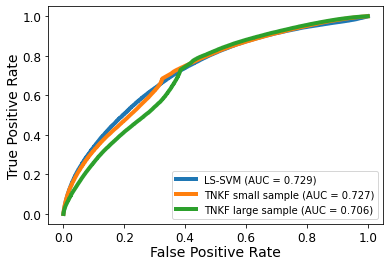

In [86]:
%matplotlib inline
plot_roc_curve_3(fpr_lssvm, tpr_lssvm, auc_lssvm,fpr_tnkf_sample, tpr_tnkf_sample, auc_tnkf_sample, fpr_tnkf, tpr_tnkf, auc_tnkf)

Save to latex compatible file

In [87]:
plt.savefig('dev_roc.png', format='png')
# plt.savefig('dev_roc.pgf', format='pgf')
tikzplotlib.save('dev_roc.tex')

<Figure size 432x288 with 0 Axes>

### Eval set

In [88]:
# fpr_tnkf, tpr_tnkf, auc_tnkf = load_and_get_roc(TNKF_DEV_FULL)
lssvm_eval = load_predictions(LSSVM_EVAL)
y_val = lssvm_eval['y_val'].to_numpy()
fpr_lssvm, tpr_lssvm, auc_lssvm = load_and_get_roc(LSSVM_EVAL)
print(auc_lssvm)

0.7971198039485461


In [89]:
fpr_tnkf_sample, tpr_tnkf_sample, auc_tnkf_sample = load_and_get_roc(TNKF_EVAL, labels=y_val)
print(auc_tnkf_sample)

0.8111631366978878


In [90]:
fpr_tnkf, tpr_tnkf, auc_tnkf = load_and_get_roc(TNKF_EVAL_FULL, labels=y_val)
print(auc_tnkf)

0.7595227643003485


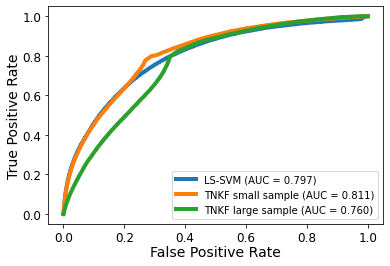

In [91]:
%matplotlib inline
# plot_roc_curve_2(fpr_lssvm, tpr_lssvm, auc_lssvm, fpr_tnkf_sample, tpr_tnkf_sample, auc_tnkf_sample)
plot_roc_curve_3(fpr_lssvm, tpr_lssvm, auc_lssvm,fpr_tnkf_sample, tpr_tnkf_sample, auc_tnkf_sample, fpr_tnkf, tpr_tnkf, auc_tnkf)

In [92]:
# plt.savefig('eval_roc.png', format='png')
plt.savefig('eval_roc_large.pgf', format='pgf')
# tikzplotlib.save('eval_roc.tex')

<Figure size 432x288 with 0 Axes>